<a href="https://colab.research.google.com/github/germankatz/altosdelparacao-statistics/blob/main/index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# http://www.ligaaltosdelparacao.com/api/zones/6232715048e5ae666545117a
# http://www.ligaaltosdelparacao.com/api/matches?matchday=6232726f48e5ae6665451197
# http://www.ligaaltosdelparacao.com/zones/6232715048e5ae666545117a

In [1]:
# Importamos librerias
from urllib.request import urlopen
import json
import pandas as pd
from numpy.ma.core import append
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict as ddict


In [2]:
zona = "6232715048e5ae666545117a"
equipo = "5a94135e7d77b75d359211d5"
nombreEquipo = "Hamaika"
colorFondo = "#1b7c3b"
colorDefault = "#0f5626"
colorHighlight = "#1daf4c"

In [3]:
# Obtengo equipo y fechas
response = urlopen("http://www.ligaaltosdelparacao.com/api/zones/" + zona)

json_data = response.read().decode('utf-8', 'replace')
d = json.loads(json_data)
dfCategoria = pd.json_normalize(d)

# Info general de los equipos de la categoría
equipos = dfCategoria["participations"][0]
dfEquipos = pd.DataFrame(equipos)

# Procesamos los equipos para que el id del team aparezca en el dataframe
idsEquipos = []
for equipoIdx, equipoRow in dfEquipos.iterrows():
  idsEquipos.append(equipoRow.team['_id'])
dfEquipos['idEquipo'] = idsEquipos

In [4]:
# En esta variable se guardarán los partidos del equipo
dfPartidosEquipo = []

partidosCategoria = pd.DataFrame(dfCategoria["matchdays"][0])
partidosPorFecha = []

for fechaZonaIdx, fechaZonaRow in partidosCategoria.iterrows():
  # Get complete matchday
  response = urlopen("http://www.ligaaltosdelparacao.com/api/matches?matchday=" + fechaZonaRow['_id'])
  json_data = response.read().decode('utf-8', 'replace')
  d = json.loads(json_data)
  dfPartidos = pd.json_normalize(d) # Partidos del día
  

  for partidoIdx, partidoRow in dfPartidos.iterrows():
    currentPartido = json.loads(partidoRow.to_json()) # Format
    # Guardo los partidos por fecha
    partidosPorFecha.append(currentPartido)
    # Busco partidos del equipo
    if currentPartido["local_team._id"] == equipo or currentPartido["visitor_team._id"] == equipo:
      dfPartidosEquipo.append(partidoRow)


Comenzamos con el procesado de datos

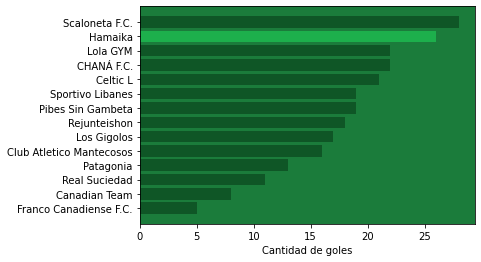

In [5]:
#######################
#### Goles a favor ####
#######################

# Mayor cantidad de gol
filtradoGoles = dfEquipos.sort_values('own_goals')

# Resaltar color hamaika
colors = []
for indx,eqp in filtradoGoles.iterrows():
    if eqp.idEquipo == equipo:
        colors.append(colorHighlight)
    else:
        colors.append(colorDefault)

fig, ax = plt.subplots()
ax.barh(filtradoGoles['team_name'], filtradoGoles['own_goals'], color=colors)
ax.set_facecolor(colorFondo)
plt.xlabel("Cantidad de goles")
plt.show()



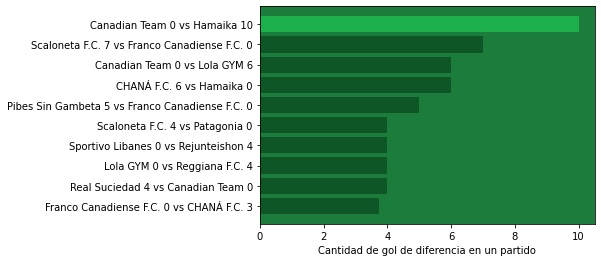

In [6]:
#######################
#### Mayor goleada ####
#######################

dfPartidosPorFecha = pd.DataFrame(partidosPorFecha)
golesDelPartido   = []
golesLocales      = []
golesVisitantes   = []
diferenciaGanador = []

for partidoIndx, partidoRow in dfPartidosPorFecha.iterrows():

  #Divido por 4 que es la cantidad de items del objeto
  golesVisitante = pd.DataFrame(partidoRow.visitor_goals).size/4
  golesLocal = pd.DataFrame(partidoRow.local_goals).size/4

  golesVisitantes   .append(str(int(golesVisitante)))
  golesLocales      .append(str(int(golesLocal)))
  golesDelPartido   .append(golesVisitante + golesLocal)
  diferenciaGanador .append(abs(golesLocal - golesVisitante))

dfPartidosPorFecha['golesTotales']      = golesDelPartido
dfPartidosPorFecha['golesLocales']      = golesLocales
dfPartidosPorFecha['golesVisitantes']   = golesVisitantes
dfPartidosPorFecha['diferenciaGanador'] = diferenciaGanador

filtradoPartidoGoles = dfPartidosPorFecha.sort_values('diferenciaGanador', ascending=False) # Ordeno por la diferencia
filtradoPartidoGoles = filtradoPartidoGoles.head(n=10) # Corto los primeros 3 mejores partidos
filtradoPartidoGoles = filtradoPartidoGoles[::-1] # Reordeno

# Resaltar color hamaika
colors = []
for _, partidoRow in filtradoPartidoGoles.iterrows():
    if (partidoRow["visitor_team._id"] == equipo or partidoRow["local_team._id"] == equipo) and partidoRow["winner"] == equipo:
        colors.append(colorHighlight)
    else:
        colors.append(colorDefault)

fig, ax = plt.subplots()

ax.barh(filtradoPartidoGoles['visitor_team_name'] + " " + filtradoPartidoGoles['golesVisitantes']  + " vs " + filtradoPartidoGoles['local_team_name'] + " " + filtradoPartidoGoles['golesLocales'] , filtradoPartidoGoles['golesTotales'], color=colors)
ax.set_facecolor(colorFondo)
plt.xlabel("Cantidad de gol de diferencia en un partido")
plt.show()


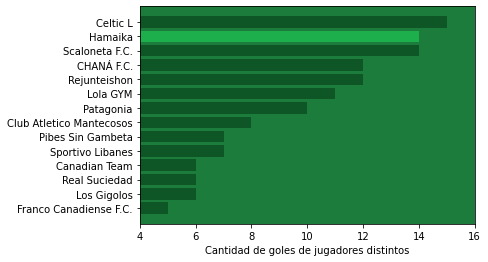

In [7]:
###############################################
#### Distribución de goles entre jugadores ####
###############################################


golesEquipo = []
for partidoIdx, partidoRow in dfPartidosPorFecha.iterrows():
  #print(partidoRow)
  # Por cada partido me guardo en la columna del equipo el id de los jugadores con goles, despues aplano
  golesVisitante = pd.DataFrame(partidoRow.visitor_goals)
  golesLocal = pd.DataFrame(partidoRow.local_goals)

  if(golesVisitante.size > 0):
    nombreEquipoVisitante = partidoRow["visitor_team.name"]
    equipoVisitante       = partidoRow["visitor_team._id"] # id del equipo visitante
    golesEquipoVisitante  = golesVisitante["player"]

    for jugador in golesEquipoVisitante:
      golesEquipo.append([nombreEquipoVisitante, equipoVisitante, jugador])

  if(golesLocal.size > 0):
    nombreEquipoLocal = partidoRow["local_team.name"]
    equipoLocal       = partidoRow["local_team._id"] # id del equipo visitante
    golesEquipoLocal  = golesLocal["player"]
    
    for jugador in golesEquipoLocal:
      golesEquipo.append([nombreEquipoLocal, equipoLocal, jugador])
  

# Agrupo por equipos los jugadores
agrupadoPorEquipo = ddict(list)
for eqp, idEquipo, player in golesEquipo:
  agrupadoPorEquipo[eqp].append(player)

equipoYGoleadoresUnicos = []
for k,v in agrupadoPorEquipo.items():  
  jugadoresDiff = set(v)
  cantJugadoresDiff = len(jugadoresDiff)
  equipoYGoleadoresUnicos.append([k, cantJugadoresDiff])
  # print(k, " con: ", str(cantJugadoresDiff), " goleadores distintos, total de goles: ", str(len(v)))

# Gráfico

# Cambio para tenerlo en dataframe
dfEquipoYGoleadoresUnicos = pd.DataFrame(equipoYGoleadoresUnicos)
dfEquipoYGoleadoresUnicos.columns = ['equipo', 'golesDif']

# Ordenamos
dfEquipoYGoleadoresUnicos = dfEquipoYGoleadoresUnicos.sort_values('golesDif')

# Resaltar color equipo
colors = []
for _,eqp in dfEquipoYGoleadoresUnicos.iterrows():
  if eqp["equipo"] == nombreEquipo:
      colors.append(colorHighlight)
  else:
      colors.append(colorDefault)

fig, ax = plt.subplots()
ax.barh(dfEquipoYGoleadoresUnicos['equipo'], dfEquipoYGoleadoresUnicos['golesDif'], color=colors)
ax.set_facecolor(colorFondo)
ax.set_xlim(4,16)
plt.xlabel("Cantidad de goles de jugadores distintos")
plt.show()

In [ ]:
##################################
#### Ganarle a los n primeros ####
##################################

# Cantidad de podio y como salio
n = 10;

# dfPartidosPorFecha tiene todos los partiods
# Primero elijo los n primeros

# dfEquipos ordernar por:
# 1 points 
# 2 diferencia de gol
# 3 goles a favor


In [ ]:
########################################
#### Porcentaje de partidos ganados ####
########################################